In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
#from bs4 import BeautifulSoup
from collections import defaultdict
#import requests
%matplotlib inline
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer

## remove special symbol
def rm_sym(df):
    df['review'] = df['review'].str.replace("&#039;",'\'')
    df['review'].head()
    df['rating_cate'] = ''
    df.loc[df['rating'] >= 7,'rating_cate'] = 'high'
    df.loc[df['rating'] <= 4,'rating_cate'] = 'low'
    df.loc[(df['rating'] > 4) & (df['rating'] < 7),'rating_cate'] = 'medium'
    return df

def clean_text(df_tem3):
    df_tem3['review'] = df_tem3['review'].str.replace("\"","").str.lower()
    df_tem3['review'] = df_tem3['review'].str.replace( r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)","")
    df_tem3['review'] = df_tem3['review'].str.replace("\"","").str.lower()
    df_tem3['review'] = df_tem3['review'].str.replace( r"(\$)|(\-)|(\\)|(\s{2,})"," ")
    df_tem3['review'].sample(1).iloc[0]

    stemmer = SnowballStemmer('english')
    df_tem3['review'] = df_tem3['review'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))
    return df_tem3


np.random.seed(9)


## input train and test data

In [4]:
df = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv',sep='\t',index_col=0)#.sample(40000)
df = rm_sym(df)
df_tem3 = df

test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
test = rm_sym(test)

df_tem3 = clean_text(df_tem3)
test = clean_text(test)

In [5]:
df_tem3.groupby('rating_cate').size()

rating_cate
high      106866
low        40075
medium     14356
dtype: int64

In [6]:
print(df_tem3.shape)
print(test.shape)

(161297, 7)
(53766, 7)


# Tensorflow

In [7]:
import tensorflow as tf
import tensorflow 

#from tensorflow import tensorflow.keras

#from keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional



# fix random seed for reproducibility

MAX_NB_WORDS = 500
max_review_length = 500
EMBEDDING_DIM = 160


## Text to sequence

In [8]:
# Tokenize the data
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None, document_count=0)

tokenizer.fit_on_texts(df_tem3['review'])
train_sequences = tokenizer.texts_to_sequences(df_tem3['review'])
test_sequences = tokenizer.texts_to_sequences(test['review'])

In [9]:
# truncate and pad input sequences
X_train = sequence.pad_sequences(train_sequences, maxlen=max_review_length)
X_test = sequence.pad_sequences(test_sequences, maxlen = max_review_length)


In [10]:
# transform y to get_dummies
y_train = pd.get_dummies(df_tem3['rating_cate'])
y_test = pd.get_dummies(test['rating_cate'])

word_index = tokenizer.word_index
y_train.head()

,high,low,medium
206461,1,0,0
95260,1,0,0
92703,0,0,1
138000,1,0,0
35696,1,0,0


In [11]:
# Print shapes of data. 

print(X_train.shape, '<-- shape of train_data ready for val/train split.')
print(X_test.shape, '<-- shape of final_test_data ready for fedding to network.')
print(len(tokenizer.word_index), '<-- Length of Word Index')

(161297, 500) <-- shape of train_data ready for val/train split.
(53766, 500) <-- shape of final_test_data ready for fedding to network.
52265 <-- Length of Word Index


## Training & Validation Data

In [12]:
# Split Training & Validation Data
from sklearn.model_selection import train_test_split


print('creating train and validation data by dividing train_data in 80:20 ratio')
######################################################

X_train_t, X_train_val, Y_train_t, y_train_val = train_test_split(X_train, y_train,test_size = 0.2)

######################################################
print('train data shape:', X_train_t.shape)
print('validation data shape:', X_train_val.shape)
print('Data is ready for training!!')

creating train and validation data by dividing train_data in 80:20 ratio
train data shape: (129037, 500)
validation data shape: (32260, 500)
Data is ready for training!!


## set up Model Sequential

In [47]:
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = max_review_length

model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=max_review_length))
#model.add(Dropout(0.2))

## add conv using kernal No.32 and size 3x3, actiation='relu'(rm neg)
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPool1D(pool_size=2))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(20)))
#model.add(Attention(max_review_length))
model.add(Dense(3, activation = 'softmax'))

## one-code mutiple categories targets use 'categorical_crossentropy' not 'binary_crossentropy'
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics =['accuracy'])

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 160)          80000     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 500, 40)           28960     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 123       
Total params: 118,843
Trainable params: 118,843
Non-trainable params: 0
_________________________________________________________________


## fit the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Run LSTM Model
batch = 32 
epoch = 40

## set name for the mdoel
training_cycle = 1
notebookname = "Drug_Data_"
variant = "LSTM_w_stopwords_"
version = "1.0_"
title = notebookname + variant + version

stamp = '{}trainging_cycle{}batchsize_{}'.format(title,training_cycle,batch)
print(stamp)

## save the best model
best_model_path = title + stamp + 'best.h5'
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only = True) ## save only best model

## if 4 steps without decreasing of loss in valid set, stop the trainning
early_stopping = EarlyStopping(patience = 4)

LSTM_model = model.fit(X_train_t, Y_train_t, batch_size=batch, epochs=epoch,
                       validation_data=(X_train_val, y_train_val),callbacks=[early_stopping], shuffle = True)

best_score = min(LSTM_model.history['val_loss'])

## why difference between train and val loss could be randomly different? local optima?
## add dropout to avoid overfitting

Drug_Data_LSTM_w_stopwords_1.0_trainging_cycle1batchsize_32


/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 129037 samples, validate on 32260 samples
Epoch 1/40
129037/129037 [==============================] - 3207s 25ms/step - loss: 0.6111 - acc: 0.7655 - val_loss: 0.5749 - val_acc: 0.7801
Epoch 2/40
129037/129037 [==============================] - 3199s 25ms/step - loss: 0.5307 - acc: 0.7988 - val_loss: 0.5070 - val_acc: 0.8073
Epoch 3/40
 58176/129037 [============>.................] - ETA: 27:38 - loss: 0.5014 - acc: 0.8078

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129037/129037 [==============================] - 3194s 25ms/step - loss: 0.4798 - acc: 0.8162 - val_loss: 0.4889 - val_acc: 0.8140
Epoch 5/40
 92928/129037 [====================>.........] - ETA: 14:04 - loss: 0.4609 - acc: 0.8232

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129037/129037 [==============================] - 3195s 25ms/step - loss: 0.4427 - acc: 0.8307 - val_loss: 0.4758 - val_acc: 0.8198
Epoch 7/40
  5088/129037 [>.............................] - ETA: 48:28 - loss: 0.4118 - acc: 0.8436

In [44]:
LSTM_model_history = pd.DataFrame(LSTM_model.history)
file_name = str(LSTM_model.params['samples']) + "_20_bilstm_2layer.csv"
LSTM_model_history.to_csv('./model_report/0403/' + file_name)
model.save('./model_report/0403/129037_20_bilstm_2layer.h5')

Text(0.5,0,'epoch')

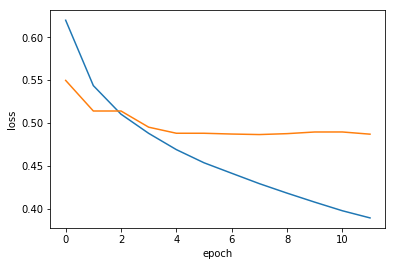

In [28]:
plt.plot(LSTM_model.history['loss'],label='train')
plt.plot(LSTM_model.history['val_loss'],label='validation')
plt.ylabel("loss")
plt.xlabel("epoch")

In [29]:
LSTM_model.history['val_acc']

[0.7949163050216987,
 0.806478611283323,
 0.8036887786732796,
 0.8123992560446374,
 0.8144141351518909,
 0.8172659640421575,
 0.8170799752014879,
 0.8185368877867328,
 0.8218226906385617,
 0.8210787352758835,
 0.8225356478611283,
 0.8233725976441414]

In [30]:
## first try
## 1000
[0.7633334,
 0.765,
 0.7733334,
 0.7766667,
 0.79,
 0.78333336,
 0.77833337,
 0.77833337,
 0.78666663]

## 10000
[0.7896667,
 0.78500015,
 0.79650015,
 0.7953333,
 0.7994998,
 0.79933333,
 0.79466665,
 0.79899997,
 0.79566664,
 0.7911668,
 0.8008332,
 0.8033334,
 0.7893331,
 0.8063332,
 0.80533326,
 0.8041667]

## 20000
[0.8406666798591613,
 0.8463333468437195,
 0.8442500100135804,
 0.8465000066757202,
 0.845666675567627,
 0.8399166750907898]

## 40000
[0.846000010728836,
 0.8528333415985108,
 0.8522500121593475,
 0.8555416769981384,
 0.829625009059906,
 0.8536250035762787,
 0.8491666755676269]

## all
[0.8746228654859085,
 0.8851105690445873,
 0.889078329655966,
 0.8945443354995075,
 0.896011581290825,
 0.8991320621279996,
 0.8992973819550564,
 0.9017668994849171,
 0.9046290611673865,
 0.908173181695814]


## add convential layer and dropout(0.2)
## 20000
[0.8463333458900452,
 0.8495833463668824,
 0.8557500090599061,
 0.8566666769981385,
 0.858500009059906,
 0.8403333406448364,
 0.8505833492279052,
 0.8565000033378601]

## 40000
[0.8470000097751618,
 0.8522500097751617,
 0.8575416767597198,
 0.8592500100135804,
 0.8623750069141388,
 0.8616666796207428,
 0.861833342552185,
 0.86329167842865]

[0.8470000097751618,
 0.8522500097751617,
 0.8575416767597198,
 0.8592500100135804,
 0.8623750069141388,
 0.8616666796207428,
 0.861833342552185,
 0.86329167842865]

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix
accr = model.evaluate(X_test,y_test, batch_size = 100)
accr

53766/53766 [==============================] - 67s 1ms/step


[0.49736629969523927, 0.8178774667864633]

In [32]:
## 10000
## [0.4519780118446444, 0.8386464840319391]

## 40000
[0.3983093709805641, 0.8546789216107478]

## all with only conv
[0.2909027664530948, 0.8856464531903855]

[0.2909027664530948, 0.8856464531903855]

In [33]:
y_test_pred = model.predict_classes(X_test)

In [34]:
y_test#.values#.argmax(axis=1)

,high,low,medium
163740,1,0,0
206473,1,0,0
159672,1,0,0
39293,1,0,0
97768,1,0,0
208087,0,1,0
215892,0,0,1
169852,1,0,0
23295,1,0,0
71428,0,1,0


In [35]:
accuracy_score(y_test.values.argmax(axis=1),y_test_pred)
## 10000
## 0.7498047092958375

## 40000
## 0.7756574787040137

## second try
## 40000
## 0.7865007625637019

0.817877469032474

In [36]:
confusion_matrix(y_test.values.argmax(axis=1),y_test_pred)

array([[33203,  1766,   471],
       [ 2816, 10223,   458],
       [ 2649,  1632,   548]])

In [37]:
y_test.sum()

high      35440
low       13497
medium     4829
dtype: int64

In [38]:
(32352+10904+981)/53766

0.8227690361938772